In [1]:
import uproot
import os
import matplotlib.pyplot as plt
import numpy as np

pjoin = os.path.join

## User inputs

In [2]:
model='VLLtau'
mass=150
background="WJetsInclusive"

In [3]:
inputdir="inputData/"

file_bkg = "VLLRun2_MVATrainingTree_WJetsInclusive_sample.root"
file_sig = f"VLLRun2_MVATrainingTree_{model}_M{mass}_sample.root"

file_sig =pjoin(inputdir,file_sig)
file_bkg =pjoin(inputdir,file_bkg)

df_sig = uproot.open(file_sig+':Events').arrays(library='pd')
df_bkg = uproot.open(file_bkg+':Events').arrays(library='pd')

print('No of signal events before any selection = ',df_sig.shape[0])
print('No of bkg events before any selection = ',df_bkg.shape[0])

print('No of total features = ',df_sig.shape[1])



No of signal events before any selection =  92961
No of bkg events before any selection =  564173
No of total features =  76


In [4]:
## Apply Signal Region Selection criteria for the 1L2J VLL analysis

selection= "lep0_iso<0.15 & dijet_mass>50 & dijet_mass<110 & deltaR_jet01<2.6"# & event_ST>250"

df_sig_sel = df_sig.query(selection)
df_bkg_sel = df_bkg.query(selection)

print('before selection...')
print('-------------------------------')
print('No of signal events before any selection = ',df_sig.shape[0])
print('No of bkg events before any selection = ',df_bkg.shape[0])
print('\nafter selection...')
print('-------------------------------')
print('No of signal events after selection = ',df_sig_sel.shape[0])
print('No of bkg events after selection = ' ,df_bkg_sel.shape[0])

print('\nNo of total features = ',df_sig_sel.shape[1])

before selection...
-------------------------------
No of signal events before any selection =  92961
No of bkg events before any selection =  564173

after selection...
-------------------------------
No of signal events after selection =  75823
No of bkg events after selection =  338686

No of total features =  76


# Train with LightGBM BDT network

In [5]:
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import time

In [6]:
df_sig_sel.columns

Index(['index', 'lep0_flavor', 'lep0_pt', 'lep0_phi', 'lep0_eta', 'lep0_iso',
       'lep0_tight', 'lep0_mt', 'lep0_sip3d', 'lep0_deepjet', 'jet0_pt',
       'jet0_phi', 'jet0_eta', 'jet0_mt', 'jet1_pt', 'jet1_phi', 'jet1_eta',
       'jet1_mt', 'dijet_mass', 'dijet_pt', 'dijet_mt', 'deltaR_jet01',
       'deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
       'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0', 'deltaPhi_dijetlep0',
       'deltaPhi_metdijet', 'event_MET', 'event_METPhi', 'event_HT',
       'event_ST', 'n_Jet', 'n_bJet', 'ljjsys_PT', 'deltaPhi_ljjsysmet',
       'deltaPhi_ljjsyslep0', 'deltaPhi_ljjsysjet0', 'deltaPhi_ljjsysjet1',
       'ljjsys_mass', 'deepjetQG_jet0', 'deepjetQG_jet1', 'event_avgQGscore',
       'event_Rpt', 'event_lepIDSF', 'event_lepIDSF_up', 'event_lepIDSF_down',
       'event_lepISOSF', 'event_lepISOSF_up', 'event_lepISOSF_down',
       'event_btagsf', 'event_btagsfCorrelated_up',
       'event_btagsfCorrelated_down', 'event_btagsfUncorrelated_up

In [7]:
def createNewColumn(df_):
    df = df_.copy()
    mybin=[0,0.2,0.5,0.8,1.01]
    mybinlabel=[1,2,3,4]
    df.loc[:,'QGjet0cat']=pd.cut(df['deepjetQG_jet0'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'QGjet1cat']=pd.cut(df['deepjetQG_jet1'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'avgQGcat'] =pd.cut(df['event_avgQGscore'],bins=mybin,labels=mybinlabel,include_lowest=True)

    return df

In [8]:
df_sig_sel=createNewColumn(df_sig_sel)
df_bkg_sel=createNewColumn(df_bkg_sel)

In [9]:

feature_list=[
'lep0_pt','lep0_eta','lep0_mt','jet0_pt','jet0_eta','jet0_mt',
'jet1_pt','jet1_eta', 'jet1_mt','dijet_pt','dijet_mt',
'deltaR_jet01','deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0',
'deltaPhi_dijetlep0','deltaPhi_metdijet',
'event_MET', 'event_HT', 'n_Jet',
'deepjetQG_jet0', 'deepjetQG_jet1','event_avgQGscore'
]
feature_list.remove('lep0_mt')
feature_list.remove('deepjetQG_jet0')
feature_list.remove('deepjetQG_jet1')
feature_list.remove('event_avgQGscore')
feature_list.append('QGjet0cat')
feature_list.append('QGjet1cat')
feature_list.append('avgQGcat')
    

## create signal and background dataframe 
- with required features and number of events
- usually bkg can be 5 times of signal

In [10]:

n_bkg_event=df_sig_sel.shape[0]+100000 

df_sig_sel_nn = df_sig_sel[feature_list]
df_bkg_sel_nn = df_bkg_sel[feature_list].sample(n_bkg_event)

df_sig_sel_nn.loc[:,'label']=1
df_bkg_sel_nn.loc[:,'label']=0

data = pd.concat([df_sig_sel_nn,df_bkg_sel_nn])


/tmp/ipykernel_241827/916526468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_sel_nn.loc[:,'label']=1


In [11]:
df_sig_sel_nn.head()

,lep0_pt,lep0_eta,jet0_pt,jet0_eta,jet0_mt,jet1_pt,jet1_eta,jet1_mt,dijet_pt,dijet_mt,...,deltaPhi_jet1lep0,deltaPhi_dijetlep0,deltaPhi_metdijet,event_MET,event_HT,n_Jet,QGjet0cat,QGjet1cat,avgQGcat,label
0,39.479763,-1.608643,74.440201,0.251892,105.194725,57.571850,-0.895630,97.020416,131.030304,142.795547,...,1.983381,1.844533,2.388688,44.983715,282.391510,3,2,2,3,1
1,70.757835,0.298462,74.913124,-1.460938,177.305344,70.621964,-0.520508,165.473267,143.893814,241.790405,...,3.116193,3.012133,2.632489,108.449142,145.535095,2,3,2,2,1
2,125.309578,-0.121704,195.473785,0.055153,281.955170,39.202419,0.091919,128.073730,222.441116,305.365753,...,2.186279,2.932411,2.773519,108.432327,234.676208,2,3,2,2,1
3,47.846752,0.740723,48.137440,1.596191,92.247627,39.371368,-0.061867,84.097816,86.618217,124.507256,...,2.619690,2.777682,3.015734,44.920135,145.334824,3,3,2,3,1
4,35.762356,1.629883,89.855247,1.334473,33.136795,64.633766,1.576660,108.442070,131.628967,90.666641,...,2.409650,1.748477,0.806350,101.427750,515.486389,5,2,2,2,1


### proceed to training

In [27]:
np.random.seed(31415)

X,y = data.values[:,:-1],data.values[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X,y,train_size=0.8)

##Normalize the input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"train stat: sig= {X_train[y_train==1].shape[0]} | bkg={X_train[y_train==0].shape[0]}")
print(f"test stat:  sig= {X_test[y_test==1].shape[0]} | bkg={X_test[y_test==0].shape[0]}")

train stat: sig= 60610 | bkg=140706
test stat:  sig= 15213 | bkg=35117


In [13]:
gbm = lgb.LGBMClassifier(learning_rate=0.05,max_depth=4,n_estimators=120,random_state=42)

starting_time = time.time()

gbm.fit(X_train, y_train)


training_time = time.time() - starting_time
print("Training time:", training_time)



[LightGBM] [Info] Number of positive: 60610, number of negative: 140706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5125
[LightGBM] [Info] Number of data points in the train set: 201316, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301069 -> initscore=-0.842213
[LightGBM] [Info] Start training from score -0.842213
Training time: 3.2300193309783936


In [14]:
y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()

In [15]:
print("auc test without weights", roc_auc_score(y_true=y_test, y_score=y_pred_gbm))

auc test without weights 0.830415703019908


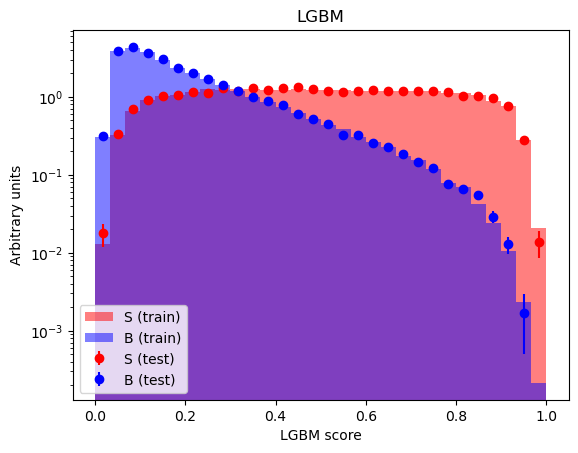

In [16]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train_gbm,
    y_train,
    y_pred_gbm,
    y_test,
    xlabel="LGBM score",
    title="LGBM",
    #weights_train=weights_train.values,
    #weights_test=weights_test.values,
    log=True
)

#plt.savefig("Score_BDT_GBM_Hist.pdf")



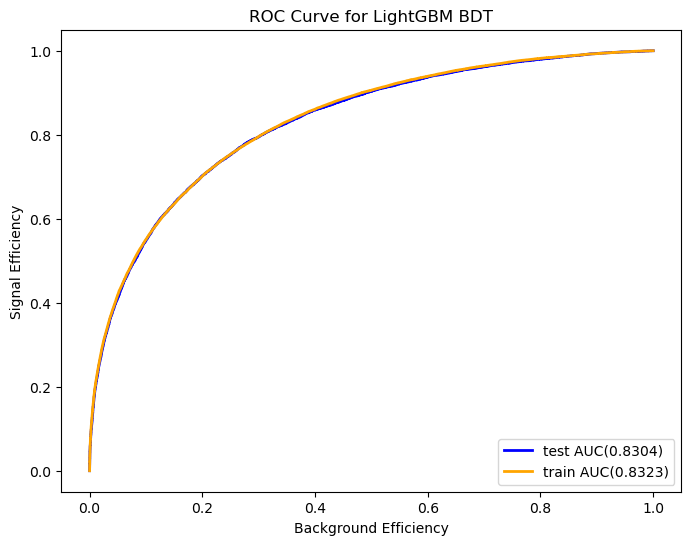

In [17]:
fpr,tpr,_ = roc_curve(y_true=y_test,y_score=y_pred_gbm)
fpr1,tpr1,_ = roc_curve(y_true=y_train,y_score=y_pred_train_gbm)

auc_value_train = roc_auc_score(y_true=y_train, y_score=y_pred_train_gbm)
auc_value_test  = roc_auc_score(y_true=y_test, y_score=y_pred_gbm)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, color='blue',lw=2,label = f'test AUC({auc_value_test:.4f})')
plt.plot(fpr1,tpr1, color='orange',lw=2,label = f'train AUC({auc_value_train:.4f})')
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC Curve for LightGBM BDT')
plt.legend(loc='lower right')
plt.show()


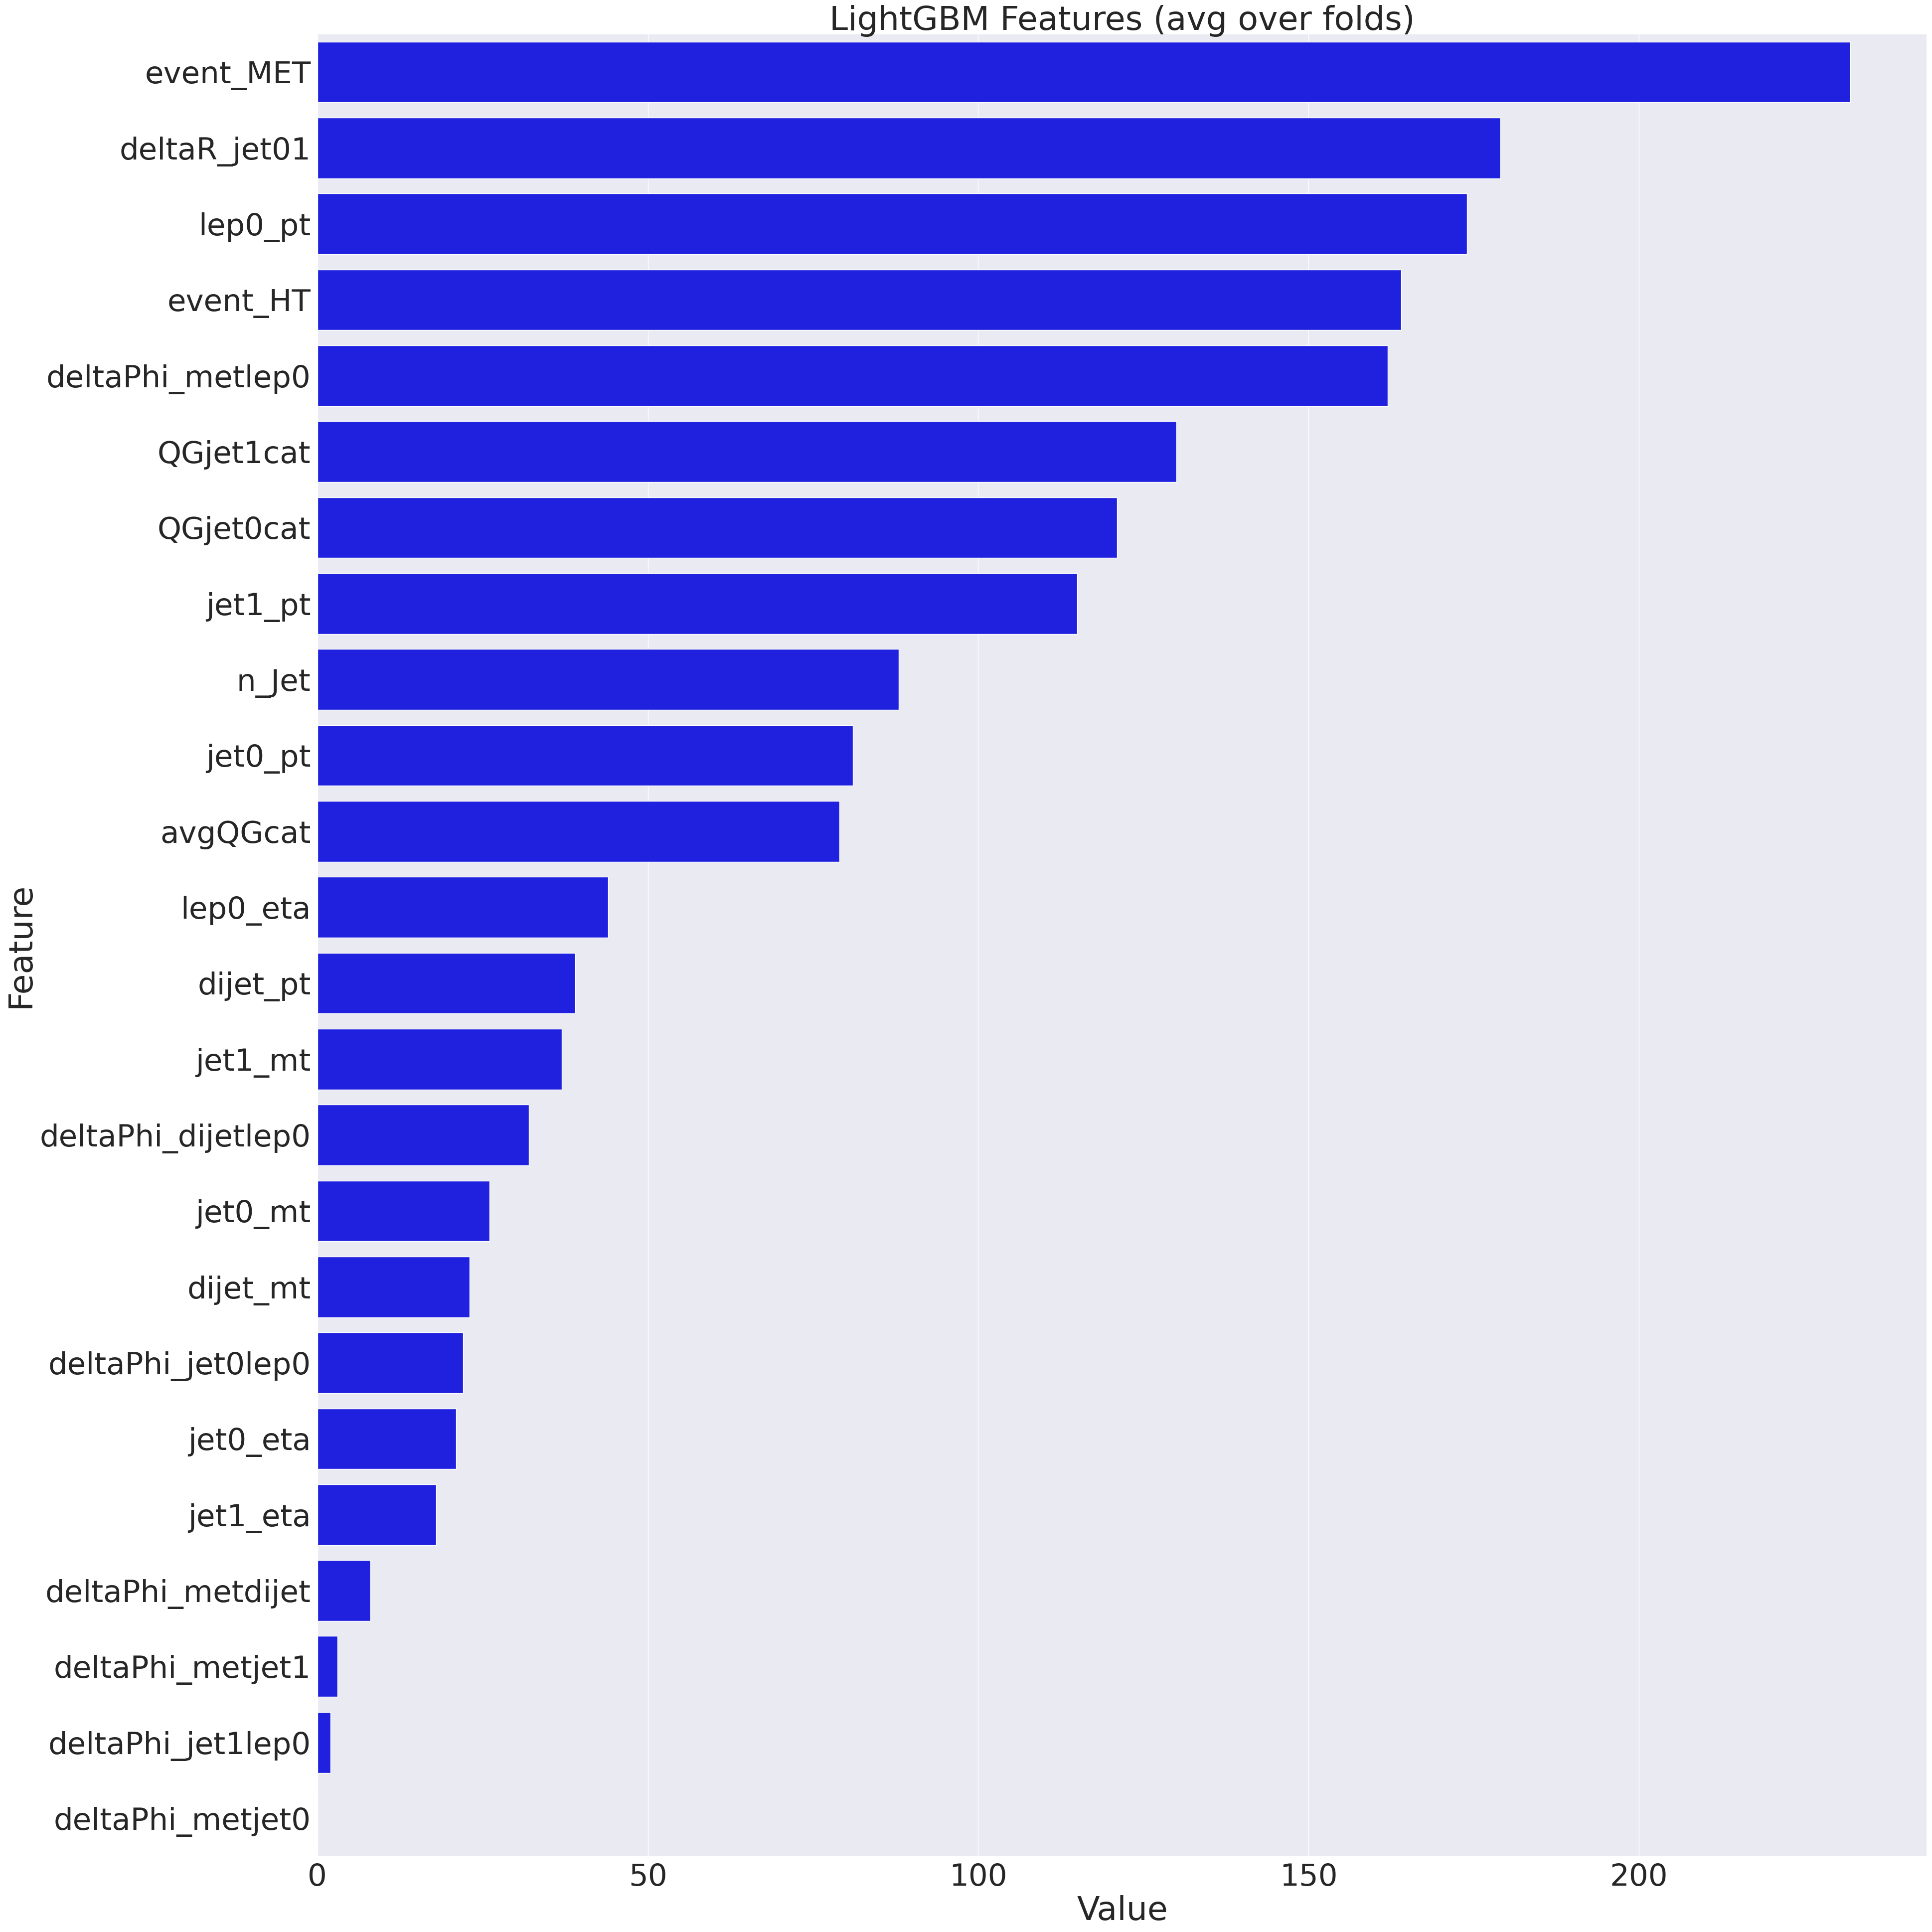

In [18]:
import seaborn as sns
import warnings
def plotImp(model, feature_list , num = 30, fig_size = (40, 40)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_list})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num],color='blue')
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(gbm,feature_list,len(feature_list))

In [19]:
# Let's make a function to avoid repetative coding
sns.set(font_scale = 1)
def plot_features(df1,df2,branch,mybins):
    
    plt.subplots(1,2,figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.hist(df1[branch],bins=mybins,lw=2,histtype='step',label='signal',color='red',density=True)
    plt.hist(df2[branch],bins=mybins,lw=2,histtype='stepfilled',label='wjets',alpha=0.5,color='blue',density=True)    
    plt.xlabel(branch)
    plt.ylabel('Events')
    plt.title(branch)
    plt.legend()
    plt.grid('-',color='gray',alpha=0.3)
    
    ##logversion
    plt.subplot(1,2,2)
    plt.hist(df1[branch],bins=mybins,lw=2,histtype='step',label='signal',color='red',density=True,log=True)
    plt.hist(df2[branch],bins=mybins,lw=2,histtype='stepfilled',label='wjets',alpha=0.5,color='blue',density=True,log=True)    
    plt.xlabel(branch)
    plt.ylabel('Events')
    plt.title(f'{branch}(log version)')
    plt.legend()
    plt.grid('-',color='gray',alpha=0.3)


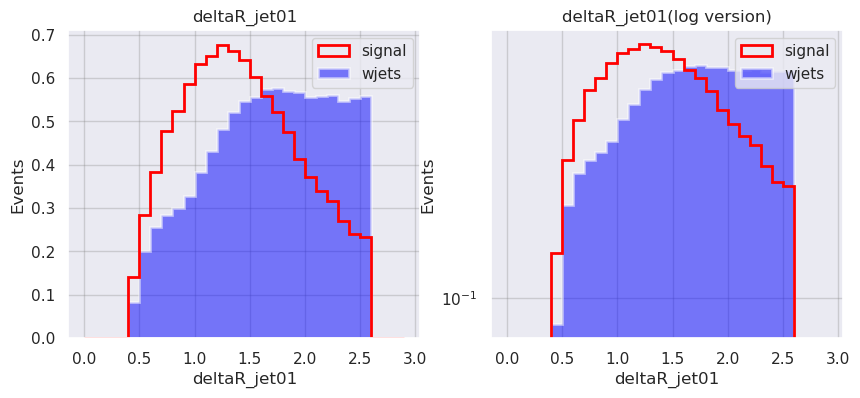

In [20]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'deltaR_jet01',mybins=np.arange(0,3,0.1))

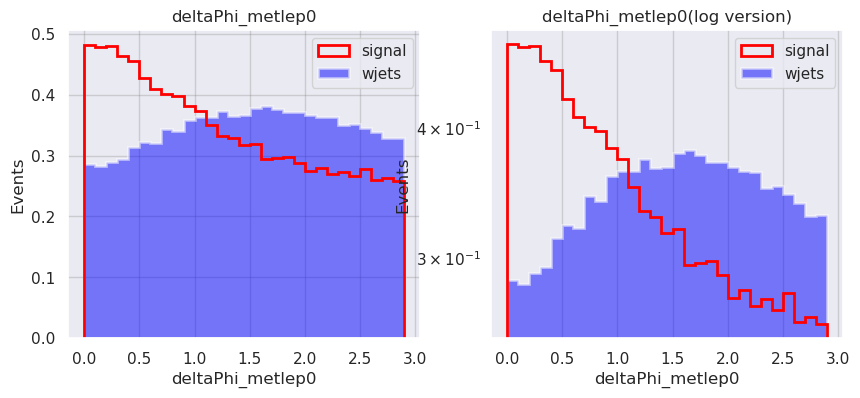

In [21]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'deltaPhi_metlep0',mybins=np.arange(0,3,0.1))

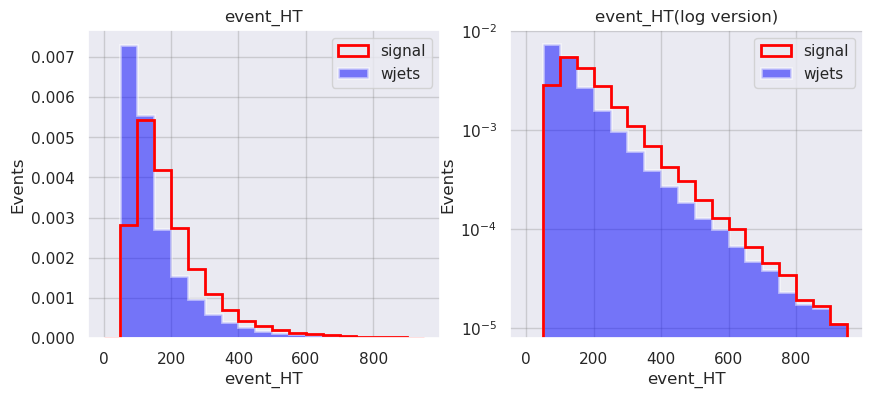

In [22]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'event_HT',mybins=np.arange(0,1000,50))

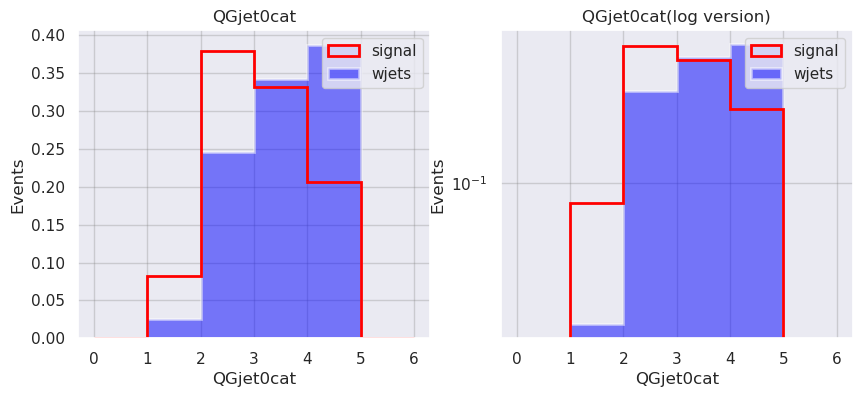

In [23]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'QGjet0cat',mybins=np.arange(0,7,1))

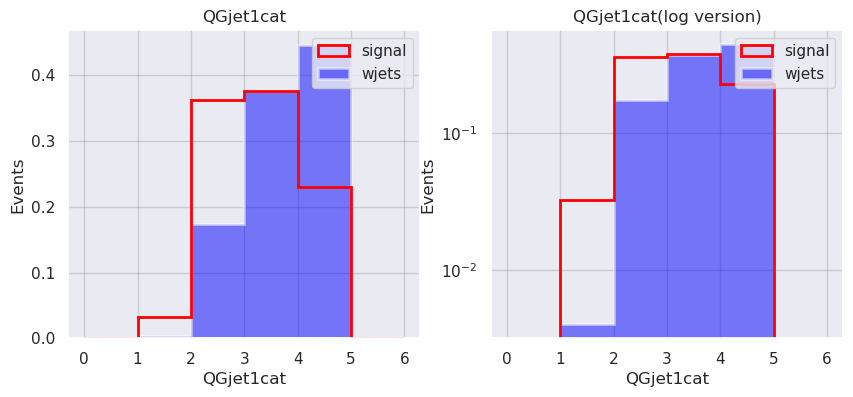

In [24]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'QGjet1cat',mybins=np.arange(0,7,1))

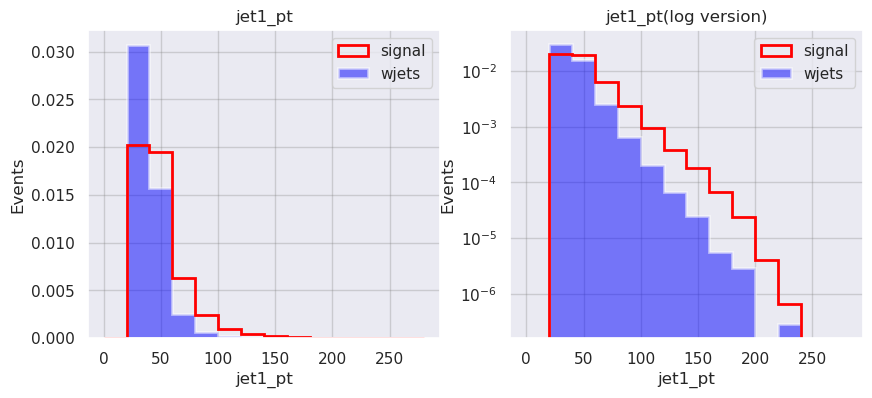

In [25]:
plot_features(df_sig_sel_nn,df_bkg_sel_nn,'jet1_pt',mybins=np.arange(0,300,20))